### Covid-19 статистика по США и Великобритании
Данные были получены с github по ссылке: https://github.com/owid/covid-19-data/tree/master/public/data

### Цели
Оценить основные показатели по Covid-19 и сравнить страны между собой по данным показателям.

In [460]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats

In [435]:
data = pd.read_csv('/home/viktor/Documents/GB_HW/Theory_of_Probability/project/owid-covid-data.csv',\
                  index_col = ['date'], sep=',', parse_dates = ['date'], decimal = '.')

In [955]:
# functions for estimating statistics of linear regression

def linearRegression(a, b):
    
    new_dict = {'var1': a, 'var2': b}
    df = pd.DataFrame(data=new_dict)
    y1 = df['var1'].values
    x1 = df['var2'].values
    # Linear Regression Method
    b1 = (np.mean(x1 * y1) - np.mean(x1) * np.mean(y1)) / (np.mean(x1 ** 2) - np.mean(x1) ** 2)
    b0 = np.mean(y1) - b1 * np.mean(x1)
    return b1, b0, y1, x1


def MAE(y_real, y_pred):
    return print(f'Ошибка: {round(np.abs((y_real - y_pred) / y_real).mean(), 3)*100}%')


def statEstimate(R, k1, n):
    k2 = n - k1 - 1
    alpha = 0.05
    F = (R2 / (1 - R2)) * (k2 / k1)
    Fc = sp.stats.f.ppf(1 - alpha, k1, k2)
    if F > Fc:
        return print(f"{F=} > {Fc=} -> уравнение регрессии статистически значимо")
    else:
        return print(f"{F=} < {Fc=} -> уравнение регрессии статистически незначимо")
    
    
def standard_error_slope(x, y, z):
    n = x.shape[0]

    upper = ((y - z) ** 2).sum() / (n - 2)
    lower = ((x - x.mean()) ** 2).sum()

    return np.sqrt(upper / lower)


def standard_error_intercept(x, y, z):
    return standard_error_slope(x, y, z) * np.sqrt((x ** 2).mean())


def b1_errorEstimate(b1, x, y, z, k1, n):
    alpha = 0.05
    s_slope = standard_error_slope(x, y, z)
    k2 = n-k1-1
    T = abs(b1 / s_slope)
    Tc = sp.stats.t.ppf(1-alpha/2, k2-2)
    if T > Tc:
        return print(f"{T=} > {Tc=} ->  гипотеза H0 (b1 = 0) отвергается => b1 значим")
    else:
        return print(f"{T=} < {Tc=} -> гипотеза H0 (b1 = 0) принимается => b1 незначим")
    

def b0__errorEstimate(b0, x, y, z, k1, n):
    alpha = 0.05
    s_intercept = standard_error_intercept(x, y, z)
    k2 = n - k1 -1
    T = b0 / s_intercept
    Tc = sp.stats.t.ppf(1-alpha/2, k2-2)
    if T > Tc:
        return print(f"{T=} > {Tc=} ->  гипотеза H0 (b0 = 0) отвергается => b0 значим")
    else:
        return print(f"{T=} < {Tc=} -> гипотеза H0 (b0 = 0) принимается => b0 незначим")
    
def b1_confidence(b1, x, y, z, k1, n):
    k2 = n - k1 - 1
    s_slope = standard_error_slope(x, y, z)
    Tc = sp.stats.t.ppf(1-alpha/2, k2)
    return print(f'95% доверительный интервал для b1:{(b1 - t * s_slope, b1 + t * s_slope)}')

def b0_confidence(b0, x, y, z, k1, n):
    k2 = n - k1 - 1
    s_intercept = standard_error_intercept(x, y, z)
    Tc = sp.stats.t.ppf(1-alpha/2, k2)
    return print(f'95% доверительный интервал для b0: {(b0 - t * s_intercept, b0 + t * s_intercept)}')
    

def disspersionAnalysis(a, b):
    k = 2
    alpha = 0.05
    a_mean = np.mean(a)
    b_mean = np.mean(b)
    n1 = len(a)
    n2 = len(b)
    all_mean = np.mean(np.concatenate([a, b]))
    S2_F = n1 * (a_mean - all_mean) ** 2 + n2 * (b_mean - all_mean) ** 2
    S2_res = ((a - a_mean) ** 2).sum() + ((b - b_mean) ** 2).sum()
    
    n = n1 + n2
    k1 = k - 1
    k2 = n - k

    sigma2_F = S2_F / k1
    sigma2_res = S2_res / k2
    
    T = sigma2_F / sigma2_res
    F_c = stats.f.ppf(1 - alpha, k1, k2)
    
    if T > F_crit:
        return print(f'{T=}>{F_c=} -> различие выборок является статистически значимым!')
    else:
        return print(f'{T=}>{F_c=} -> различие выборок незначимо!')

In [980]:
### supporting functions 

def calcAverage(data):
    cases_per_month = dict()
    new_cases = []
    month = 1
    n = 1

    for i in data:
        new_cases.append(i)
        if n % 30 == 0:
            cases_per_month.update({month:new_cases})
            new_cases = []
            month += 1
        n += 1
    return pd.DataFrame.from_dict(cases_per_month)


def meanPerMonth(data, n):
    mean_cases = []
    
    for i in data:
        if i >= n:
            x = data[i].values
            val = np.nanmean(x)
            if pd.isnull(val):
                mean_cases.append(0)
            else:
                mean_cases.append(val)
    return mean_cases

### Covid statistics for USA

In [444]:
df_us = data[data['iso_code'] == 'USA']
df_us.head()

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,USA,North America,United States,1.0,NaN,NaN,NaN,NaN,NaN,0.003,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
2020-01-23,USA,North America,United States,1.0,0.0,NaN,NaN,NaN,NaN,0.003,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
2020-01-24,USA,North America,United States,2.0,1.0,NaN,NaN,NaN,NaN,0.006,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
2020-01-25,USA,North America,United States,2.0,0.0,NaN,NaN,NaN,NaN,0.006,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
2020-01-26,USA,North America,United States,5.0,3.0,NaN,NaN,NaN,NaN,0.015,...,19.1,24.6,NaN,2.77,78.86,0.926,-8988.0,-3.62,-2.65,-26.997876


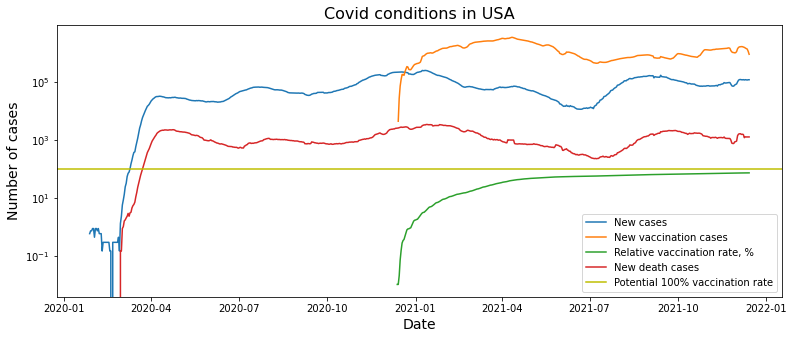

In [544]:
plt.figure(figsize = (13, 5))
plt.plot(df_us.new_cases_smoothed, label = 'New cases')
plt.plot(df_us.new_vaccinations_smoothed, label = 'New vaccination cases')
plt.plot(df_us.people_vaccinated_per_hundred, label = 'Relative vaccination rate, %')
plt.plot(df_us.new_deaths_smoothed, label = 'New death cases')
plt.yscale('log')
plt.axhline(y=100, color='y', linestyle='-', label = 'Potential 100% vaccination rate')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Number of cases', fontsize = 14)
plt.title('Covid conditions in USA', fontsize = 16)
plt.legend()
plt.show()

### ГИПОТЕЗА
Скорость вакцинации населения уменьшает рост новых случаев Covid-19
### ЗАДАЧА
Оценить корреляцию новых случаев в США Covid-19 от скорости вакцинации

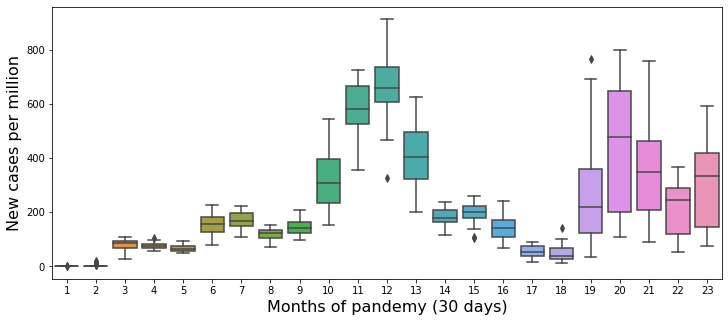

In [855]:
cases_per_month_us = calcAverage(df_us.new_cases_per_million)

plt.figure(figsize = (12, 5))
sns.boxplot(data=cases_per_month_us)
plt.ylabel('New cases per million', fontsize = 16)
plt.xlabel('Months of pandemy (30 days)', fontsize = 16)
plt.show()

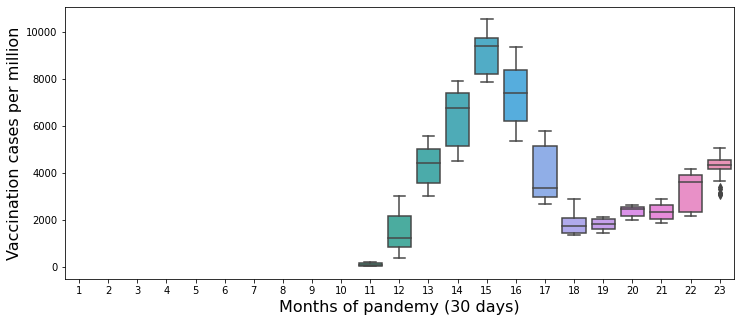

In [843]:
vaccine_per_month_us = calcAverage(df_us.new_vaccinations_smoothed_per_million)

plt.figure(figsize = (12, 5))
sns.boxplot(data=vaccine_per_month_us)
plt.ylabel('Vaccination cases per million', fontsize = 16)
plt.xlabel('Months of pandemy (30 days)', fontsize = 16)
plt.show()

In [847]:
mean_cases_us = meanPerMonth(cases_per_month_us, 11)
mean_vaccine_us = meanPerMonth(vaccine_per_month_us, 11)

print(mean_cases_us)
print(mean_vaccine_us)

[582.6233333333333, 658.2042000000001, 407.3829, 184.3437333333334, 195.31053333333332, 143.53223333333335, 55.03263333333333, 47.97943333333333, 267.0930333333333, 441.0033, 350.70820000000003, 226.4186, 302.0389333333333]
[104.33333333333333, 1451.4333333333334, 4316.5, 6374.366666666667, 9133.533333333333, 7343.533333333334, 3951.6, 1836.7666666666667, 1807.8, 2366.8, 2357.766666666667, 3209.4333333333334, 4225.4]


In [848]:
b1, b0, y1, x1 = linearRegression(mean_cases_us, mean_vaccine_us)
print(b1, b0)

-0.03711533764977074 435.46118600102125


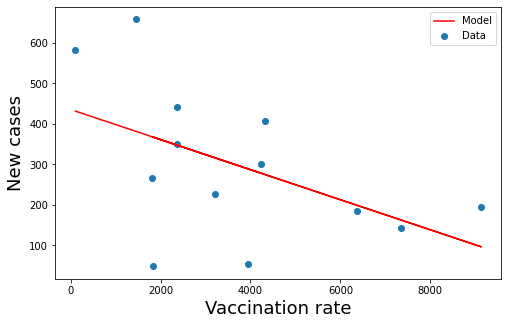

In [849]:
ox = x1
oy = b0 + b1 * ox

plt.figure(figsize = (8, 5))
plt.scatter(x1, y1, label='Data')
plt.plot(ox, oy, color='red', label='Model')
plt.xlabel('Vaccination rate', fontsize = 18)
plt.ylabel('New cases', fontsize = 18)
plt.legend(loc='best')
plt.show()

In [856]:
z1 = b0 + b1 * x1

print(f'real: {y1}')
print(f'pred: {z1}')

MAE(y1, z1)

real: [582.62333333 658.2042     407.3829     184.34373333 195.31053333
 143.53223333  55.03263333  47.97943333 267.09303333 441.0033
 350.7082     226.4186     302.03893333]
pred: [431.58881911 381.59074776 275.25283104 198.87441486  96.4670124
 162.90346679 288.79621774 367.28897098 368.3640786  347.61660485
 347.95188007 316.34198417 278.6340383 ]
Ошибка: 105.4%


In [857]:
### Coefficient of determination
R2 = z1.var() / y1.var()
print(f'The coefficient of determination: {R2}')

n = len(y1)
statEstimate(R, 1, n)

The coefficient of determination: 0.2602440469883286
F=3.8697688139137543 < Fc=4.844335674943618 -> уравнение регрессии статистически незначимо


### Вывод
В США статистически значимая зависимость между новыми случаями Covid-19 и скоростью вакцинации не прослеживается.

### Новая гипотеза
Уровень вакцинации населения уменьшает среднюю смертность от Covid-19.

### Задача
Оценить корреляцию между уровнем вакцинации населения и средним уровнем смертности от Covid-19.

In [588]:
### calculation average death rate
new_death_per_million_us = calcAverage(df_us.new_deaths_per_million)
vaccination_rate_us = calcAverage(df_us.total_vaccinations_per_hundred)

new_death_per_million_us.head()

,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
0,NaN,NaN,0.384,7.458,3.587,1.721,1.589,3.866,2.884,1.391,...,2.851,3.656,2.586,0.793,1.003,0.979,0.763,6.590,9.684,7.560
1,NaN,NaN,0.562,7.380,3.617,0.952,3.292,3.325,2.136,1.472,...,4.938,4.950,2.127,1.183,1.150,1.075,0.529,5.788,6.431,1.493
2,NaN,NaN,0.730,7.281,3.226,1.135,3.680,3.307,0.811,2.815,...,7.347,3.142,0.988,2.343,0.952,0.201,3.163,8.308,5.476,0.517
3,NaN,NaN,1.000,6.515,1.925,2.220,3.262,2.941,1.241,3.526,...,7.831,2.322,1.514,2.055,1.844,0.520,3.088,10.396,1.418,3.929
4,NaN,NaN,1.253,5.203,1.793,2.268,3.286,1.487,3.109,2.574,...,7.615,2.373,2.544,2.055,0.526,0.601,3.529,7.347,1.280,3.959


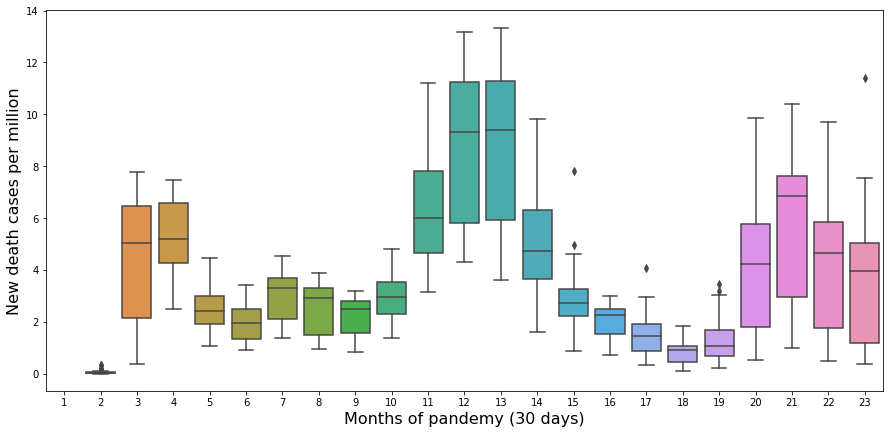

In [589]:
plt.figure(figsize = (15, 7))
sns.boxplot(data=new_death_per_million_us)
plt.ylabel('New death cases per million', fontsize = 16)
plt.xlabel('Months of pandemy (30 days)', fontsize = 16)
plt.show()

In [787]:
mean_death_us = meanPerMonth(new_death_per_million_us, 11)
mean_vaccination_us = meanPerMonth(vaccination_rate_us, 11)

print(mean_death_us)
print(mean_vaccination_us)

[6.356533333333334, 8.719133333333332, 8.809366666666667, 4.966400000000003, 2.8137, 2.040966666666667, 1.4499, 0.8220333333333334, 1.3219666666666667, 3.9783333333333335, 5.7595, 4.280466666666666, 3.6335999999999995]
[0.027500000000000004, 2.0406666666666666, 11.64466666666667, 28.122333333333334, 52.602666666666664, 78.42766666666667, 93.96399999999998, 101.43333333333332, 106.35200000000002, 113.07433333333333, 119.88399999999997, 128.13766666666666, 140.14600000000002]


In [788]:
b1, b0, y1, x1 = linearRegression(mean_death_us[0:-1], mean_vaccination_us[0:-1])
print(b1, b0)

-0.03729022264294441 6.873511920010051


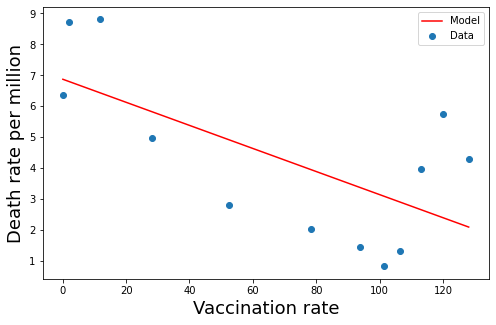

In [789]:
ox = x1
oy = b0 + b1 * ox

plt.figure(figsize = (8, 5))
plt.scatter(x1, y1, label='Data')
plt.plot(ox, oy, color='red', label='Model')
plt.xlabel('Vaccination rate', fontsize = 18)
plt.ylabel('Death rate per million', fontsize = 18)
plt.legend(loc='best')
plt.show()

In [790]:
z1 = b0 + b1 * x1

print(f'real: {y1}')
print(f'pred: {z1}')

MAE(y1, z1)

real: [6.35653333 8.71913333 8.80936667 4.9664     2.8137     2.04096667
 1.4499     0.82203333 1.32196667 3.97833333 5.7595     4.28046667]
pred: [6.87248644 6.79741501 6.43927971 5.82482385 4.91194677 3.94892677
 3.36957344 3.09104034 2.90762216 2.65694485 2.40301087 2.0952298 ]
Ошибка: 76.1%


In [791]:
### Coefficient of determination
R2 = z1.var() / y1.var()
print(f'The coefficient of determination: {R2}')

n = len(y1)
statEstimate(R, 1, n)

The coefficient of determination: 0.42894267232044153
F=7.511376731008996 > Fc=4.9646027437307145 -> уравнение регрессии статистически значимо


In [600]:
n = len(y1)

b1_errorEstimate(b1, x1, y1, z1, 1, n)
b0__errorEstimate(b0, x1, y1, z1, 1, n)

T=2.677525915341367 > Tc=2.2621571627409915 ->  гипотеза H0 (b1 = 0) отвергается => b1 значим
T=6.0946365644386455 > Tc=2.2621571627409915 ->  гипотеза H0 (b0 = 0) отвергается => b0 значим


In [601]:
b1_confidence(b1, x1, y1, z1, 1, n)
b0_confidence(b0, x1, y1, z1, 1, n)

95% доверительный интервал для b1:(-0.061450830850485805, -0.0045812094826139516)
95% доверительный интервал для b0: (4.168337324348513, 9.24255635088208)


### Вывод
Существует статистически значимая корреляция между средней смертностью от Covid-19 и уровнем вакцинации населения в США.

### Covid statistics for United Kingdom

In [546]:
df_uk = data[data['iso_code'] == 'GBR']
df_uk.head()

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-01-31,GBR,Europe,United Kingdom,2.0,2.0,NaN,NaN,NaN,NaN,0.029,...,20.0,24.7,NaN,2.54,81.32,0.932,NaN,NaN,NaN,NaN
2020-02-01,GBR,Europe,United Kingdom,2.0,0.0,NaN,NaN,NaN,NaN,0.029,...,20.0,24.7,NaN,2.54,81.32,0.932,NaN,NaN,NaN,NaN
2020-02-02,GBR,Europe,United Kingdom,2.0,0.0,NaN,NaN,NaN,NaN,0.029,...,20.0,24.7,NaN,2.54,81.32,0.932,-1956.3,-2.68,-5.6,-28.681759
2020-02-03,GBR,Europe,United Kingdom,8.0,6.0,NaN,NaN,NaN,NaN,0.117,...,20.0,24.7,NaN,2.54,81.32,0.932,NaN,NaN,NaN,NaN
2020-02-04,GBR,Europe,United Kingdom,8.0,0.0,NaN,NaN,NaN,NaN,0.117,...,20.0,24.7,NaN,2.54,81.32,0.932,NaN,NaN,NaN,NaN


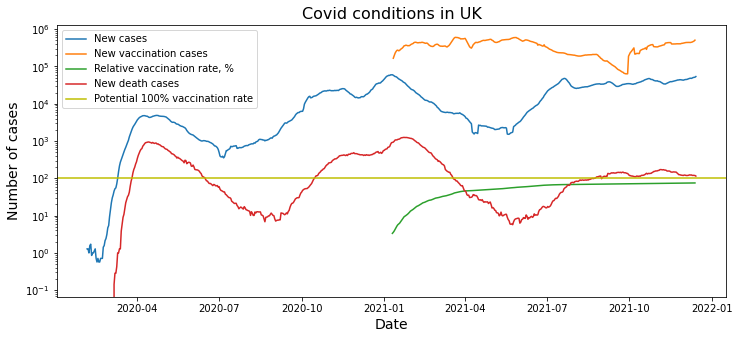

In [545]:
plt.figure(figsize = (12, 5))
plt.plot(df_uk.new_cases_smoothed, label = 'New cases')
plt.plot(df_uk.new_vaccinations_smoothed, label = 'New vaccination cases')
plt.plot(df_uk.people_vaccinated_per_hundred, label = 'Relative vaccination rate, %')
plt.plot(df_uk.new_deaths_smoothed, label = 'New death cases')
plt.yscale('log')
plt.axhline(y=100, color='y', linestyle='-', label = 'Potential 100% vaccination rate')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Number of cases', fontsize = 14)
plt.title('Covid conditions in UK', fontsize = 16)
plt.legend()
plt.show()

### Проверим те же величины на корреляцию в Великобритании:
Оценим корреляцию новых случаев Covid-19 и скоростью вакцинации населения.

In [858]:
### calculate average cases per month 
cases_per_month_uk = calcAverage(df_uk.new_cases_per_million)

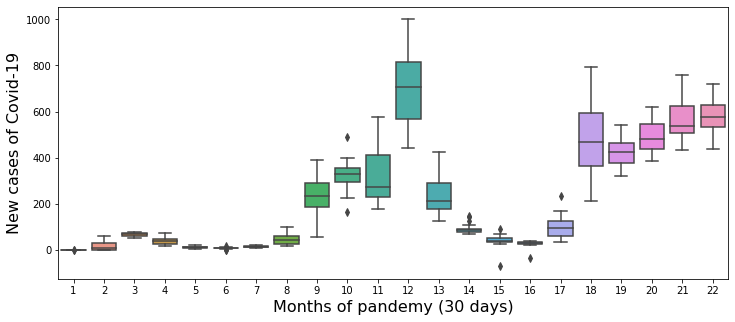

In [873]:
plt.figure(figsize = (12, 5))
sns.boxplot(data=cases_per_month_uk)
plt.ylabel('New cases of Covid-19', fontsize = 16)
plt.xlabel('Months of pandemy (30 days)', fontsize = 16)
plt.show()

In [860]:
### calculate average vaccination rate per month 
vaccine_per_month_uk = calcAverage(df_uk.new_vaccinations_smoothed_per_million)

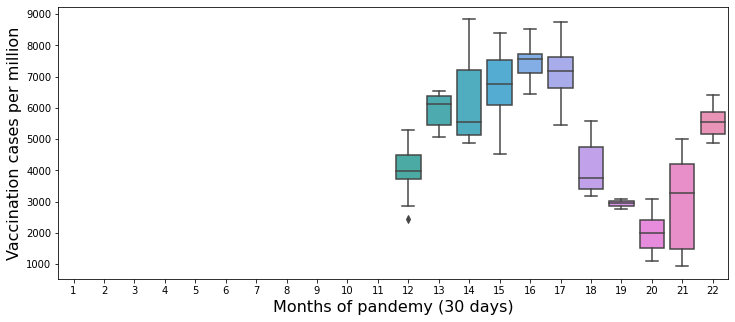

In [874]:
plt.figure(figsize = (12, 5))
sns.boxplot(data=vaccine_per_month_uk)
plt.ylabel('Vaccination cases per million', fontsize = 16)
plt.xlabel('Months of pandemy (30 days)', fontsize = 16)
plt.show()

In [875]:
mean_cases_uk = meanPerMonth(cases_per_month_uk, 12)
mean_vaccination_rate_uk = meanPerMonth(vaccine_per_month_uk, 12)

print(mean_cases_uk)
print(mean_vaccination_rate_uk)

[698.8077999999999, 238.92863333333338, 90.97873333333334, 41.92530000000001, 30.324266666666666, 99.31813333333334, 478.3724333333333, 420.64289999999994, 492.79260000000005, 561.9517, 574.6531]
[4034.5, 5938.0, 6199.266666666666, 6752.433333333333, 7433.8, 7197.8, 4077.8333333333335, 2944.3, 2013.6, 3062.7, 5585.7]


In [876]:
b1, b0, y1, x1 = linearRegression(mean_cases_uk, mean_vaccination_rate_uk)
print(b1, b0)

-0.10201342413025065 851.2645770963732


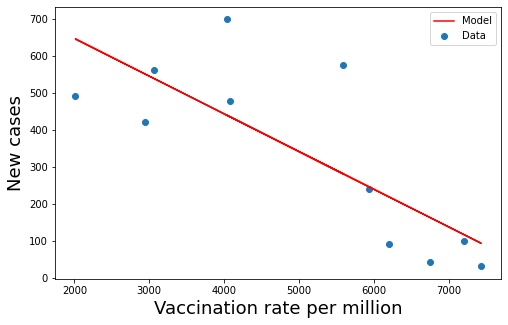

In [877]:
ox = x1
oy = b0 + b1 * ox

plt.figure(figsize = (8, 5))
plt.scatter(x1, y1, label='Data')
plt.plot(ox, oy, color='red', label='Model')
plt.xlabel('Vaccination rate per million', fontsize = 18)
plt.ylabel('New cases', fontsize = 18)
plt.legend(loc='best')
plt.show()

In [878]:
z1 = b0 + b1 * x1

print(f'real: {y1}')
print(f'pred: {z1}')

MAE(y1,z1)

real: [698.8078     238.92863333  90.97873333  41.9253      30.32426667
  99.31813333 478.37243333 420.6429     492.7926     561.9517
 574.6531    ]
pred: [439.69141744 245.50886461 218.85615733 162.42573155  92.9171848
 116.99235289 435.27083573 550.90645243 645.85034627 538.82806301
 281.44819393]
Ошибка: 74.4%


In [879]:
### Coefficient of determination
R2 = z1.var() / y1.var()
print(f'The coefficient of determination: {R2}')

n = len(y1)
statEstimate(R, 1, n)

The coefficient of determination: 0.6129608035412464
F=14.253458777163209 > Fc=5.117355029199227 -> уравнение регрессии статистически значимо


In [880]:
n = len(y1)

b1_errorEstimate(b1, x1, y1, z1, 1, n)
b0__errorEstimate(b0, x1, y1, z1, 1, n)

b1_confidence(b1, x1, y1, z1, 1, n)
b0_confidence(b0, x1, y1, z1, 1, n)

T=3.7753753160663694 > Tc=2.3646242510102993 ->  гипотеза H0 (b1 = 0) отвергается => b1 значим
T=5.910078723844469 > Tc=2.3646242510102993 ->  гипотеза H0 (b0 = 0) отвергается => b0 значим
95% доверительный интервал для b1:(-0.16432324404226453, -0.03970360421823676)
95% доверительный интервал для b0: (519.1173745786871, 1183.4117796140592)


### Вывод
В отличие от США в Великобритании наблюдается статистически значимая обратная корреляция между новыми случами Covid и скоростью вакцинации.

### Задача
Оценить корреляцию между уровнем вакцинации населения и средним уровнем смертности от Covid-19 в Великобритании.

In [881]:
### calculation average death rate
new_death_per_million_uk = calcAverage(df_uk.new_deaths_per_million)
vaccination_rate_uk = calcAverage(df_uk.total_vaccinations_per_hundred)

new_death_per_million_uk.head()

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
0,NaN,NaN,5.923,9.325,2.258,0.308,0.498,0.132,0.249,5.381,...,8.709,6.495,1.041,0.161,0.220,0.308,1.290,0.616,2.463,2.654
1,NaN,NaN,9.867,10.263,0.880,0.792,0.000,0.176,0.191,4.545,...,23.986,4.750,0.850,0.103,0.132,0.264,0.411,2.551,2.859,1.979
2,NaN,NaN,9.632,8.577,1.261,1.422,0.293,0.015,1.056,4.105,...,25.305,5.058,0.308,0.249,0.147,0.337,0.205,2.185,2.639,1.056
3,NaN,NaN,10.805,3.709,3.665,0.601,0.191,0.044,1.041,4.017,...,18.165,4.266,0.337,0.425,0.147,0.161,1.921,2.082,1.891,0.586
4,NaN,NaN,11.099,4.003,3.724,0.718,0.073,0.044,0.865,4.780,...,18.297,2.111,0.806,0.367,0.103,0.044,1.862,1.481,0.938,3.856


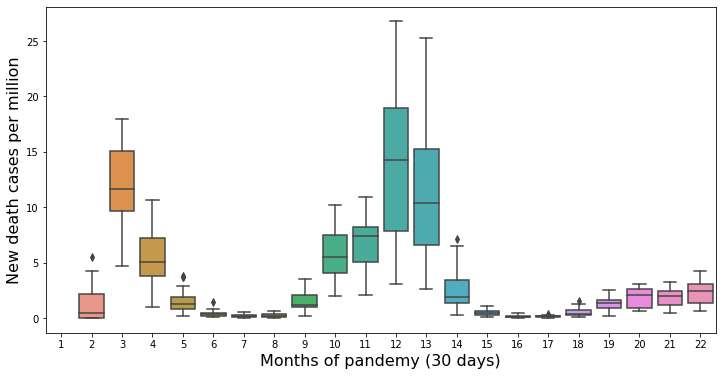

In [882]:
plt.figure(figsize = (12, 6))
sns.boxplot(data=new_death_per_million_uk)
plt.ylabel('New death cases per million', fontsize = 16)
plt.xlabel('Months of pandemy (30 days)', fontsize = 16)
plt.show()

In [883]:
mean_death_uk = meanPerMonth(new_death_per_million_uk, 12)
mean_vaccination_uk = meanPerMonth(vaccination_rate_uk, 12)

print(mean_death_uk)
print(mean_vaccination_uk)

[13.599266666666667, 11.439133333333332, 2.515833333333333, 0.4818333333333332, 0.1544666666666666, 0.14913333333333334, 0.5077333333333334, 1.2843333333333333, 1.8741999999999999, 1.841933333333333, 2.3194333333333335]
[6.819333333333333, 19.580333333333336, 37.01200000000001, 57.765666666666675, 78.86166666666668, 101.63499999999999, 117.35466666666666, 126.88733333333334, 134.501, 141.01566666666668, 155.55733333333333]


In [884]:
b1, b0, y1, x1 = linearRegression(mean_death_uk[0:-1], mean_vaccination_uk[0:-1])
print(b1, b0)

-0.0716718127743089 9.272143495870129


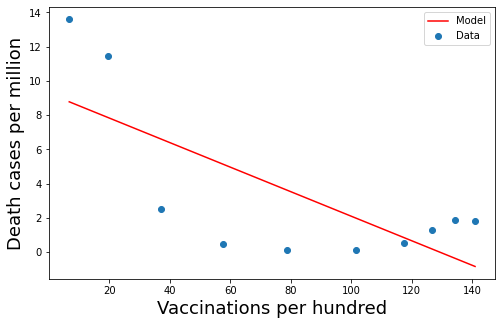

In [885]:
ox = x1
oy = b0 + b1 * ox

plt.figure(figsize = (8, 5))
plt.scatter(x1, y1, label='Data')
plt.plot(ox, oy, color='red', label='Model')
plt.xlabel('Vaccinations per hundred', fontsize = 18)
plt.ylabel('Death cases per million', fontsize = 18)
plt.legend(loc='best')
plt.show()

In [886]:
z1 = b0 + b1 * x1

print(f'real: {y1}')
print(f'pred: {z1}')

MAE(y1, z1)

real: [13.59926667 11.43913333  2.51583333  0.48183333  0.15446667  0.14913333
  0.50773333  1.28433333  1.8742      1.84193333]
pred: [ 8.78338951  7.86878551  6.61942636  5.13197345  3.61998489  1.9877788
  0.8611218   0.1778983  -0.36778699 -0.83470496]
Ошибка: 509.2%


In [887]:
### Coefficient of determination
R2 = z1.var() / y1.var()
print(f'The coefficient of determination: {R2}')

n = len(y1)
statEstimate(R, 1, n)

The coefficient of determination: 0.5230302755082978
F=8.772553034734967 > Fc=5.317655071578714 -> уравнение регрессии статистически значимо


### Оценка полученной статистики:
Ошибка между наблюдаемыми и моделируемыми значениями довольно высокая, вероятно, это связано с другими дополнительными факторами, которые не представленны в таблице. В то же время уравнение регрессии удовлетворяет критерию Фишера, поэтому найдем оценки ошибок коэффициентов линейной регрессии.

In [784]:
n = len(y1)

b1_errorEstimate(b1, x1, y1, z1, 1, n)
b0__errorEstimate(b0, x1, y1, z1, 1, n)

b1_confidence(b1, x1, y1, z1, 1, n)
b0_confidence(b0, x1, y1, z1, 1, n)

T=2.9618495969132117 > Tc=2.4469118487916806 ->  гипотеза H0 (b1 = 0) отвергается => b1 значим
T=4.049495399947177 > Tc=2.4469118487916806 ->  гипотеза H0 (b0 = 0) отвергается => b0 значим
95% доверительный интервал для b1:(-0.12747316083391438, -0.015870464714703415)
95% доверительный интервал для b0: (3.9920873926441756, 14.552199599096081)


### Сравнение США и Великобритании
1. Сравнение среднего уровня новых случаев Covid-19 в месяц на миллион человек
2. Сравнение среднего уровня госпитализации на миллион человек
3. Сравнение среднего уровня смертности на миллион человек

In [889]:
mean_cases_us = meanPerMonth(cases_per_month_us, 1)
print(mean_cases_us)

[0.0013448275862068967, 2.6043666666666665, 77.39673333333334, 76.35283333333332, 66.03566666666667, 156.08263333333332, 170.69923333333332, 119.64670000000002, 143.99159999999998, 320.2694666666667, 582.6233333333333, 658.2042000000001, 407.3829, 184.3437333333334, 195.31053333333332, 143.53223333333335, 55.03263333333333, 47.97943333333333, 267.0930333333333, 441.0033, 350.70820000000003, 226.4186, 302.0389333333333]


In [891]:
mean_cases_uk = meanPerMonth(cases_per_month_uk, 1)
print(mean_cases_uk)

[0.0299, 16.7235, 68.1874, 39.85649999999999, 14.0895, 8.830366666666666, 14.7824, 48.5336, 227.70013333333333, 324.0781, 326.0051, 698.8077999999999, 238.92863333333338, 90.97873333333334, 41.92530000000001, 30.324266666666666, 99.31813333333334, 478.3724333333333, 420.64289999999994, 492.79260000000005, 561.9517, 574.6531]


In [956]:
disspersionAnalysis(mean_cases_us, mean_cases_uk)


T=0.0009000408022989714>F_c=4.067047426426355 -> разлиие выборок незначимо!


Между США и Великобританией не наблюдается статистическое различие между новыми случаями Covid-19

In [984]:
hospitalisation_us = calcAverage(df_us.hosp_patients_per_million)
mean_hosp_us = meanPerMonth(hospitalisation_us, 1)

hospitalisation_uk = calcAverage(df_uk.hosp_patients_per_million)
mean_hosp_uk = meanPerMonth(hospitalisation_uk, 1)

/tmp/ipykernel_8871/1416121995.py:25: RuntimeWarning: Mean of empty slice
  val = np.nanmean(x)


In [987]:
print(mean_hosp_us)
print(mean_hosp_uk)

[0, 0, 0, 0, 0, 114.51019999999998, 132.27446666666665, 92.39146666666666, 87.16990000000001, 149.94663333333335, 283.54773333333327, 366.20039999999995, 281.89056666666664, 135.90983333333332, 107.83186666666667, 103.92173333333334, 58.04723333333333, 41.5159, 137.12856666666667, 279.8230333333333, 219.38970000000003, 137.55183333333332, 151.09196666666665]
[0, 132.5485, 270.1463, 162.2440666666667, 76.67046666666667, 31.91893333333333, 15.318000000000003, 16.32813333333333, 78.23576666666666, 220.92563333333334, 260.88236666666666, 484.11659999999995, 381.2334666666667, 131.28153333333336, 41.6862, 16.9694, 16.23633333333333, 44.79743333333332, 88.82113333333334, 113.25103333333333, 104.4559, 129.4333]


In [988]:
disspersionAnalysis(mean_hosp_us, mean_hosp_uk)

T=0.006845277648990469>F_c=4.067047426426355 -> разлиие выборок незначимо!


Между США и Великобританией не наблюдается статистическое различие между средним числом госпитализаций.

In [996]:
death_rate_us = calcAverage(df_us.new_deaths_per_million)
mean_death_us = meanPerMonth(death_rate_us, 1)

print(mean_death_us)

death_rate_uk = calcAverage(df_uk.new_deaths_per_million)
mean_death_uk = meanPerMonth(death_rate_uk, 1)

print(mean_death_uk)

[0, 0.06477272727272727, 4.475966666666667, 5.1938666666666675, 2.4662999999999995, 1.9401000000000002, 3.0555333333333334, 2.578933333333333, 2.235233333333333, 2.8726666666666665, 6.356533333333334, 8.719133333333332, 8.809366666666667, 4.966400000000003, 2.8137, 2.040966666666667, 1.4499, 0.8220333333333334, 1.3219666666666667, 3.9783333333333335, 5.7595, 4.280466666666666, 3.6335999999999995]
[0, 1.20392, 11.760766666666665, 5.471133333333332, 1.5106, 0.3987666666666667, 0.1681, 0.24233333333333335, 1.4798333333333331, 5.6407333333333325, 6.681633333333334, 13.599266666666667, 11.439133333333332, 2.515833333333333, 0.4818333333333332, 0.1544666666666666, 0.14913333333333334, 0.5077333333333334, 1.2843333333333333, 1.8741999999999999, 1.841933333333333, 2.3194333333333335]


/tmp/ipykernel_8871/1416121995.py:25: RuntimeWarning: Mean of empty slice
  val = np.nanmean(x)


In [998]:
disspersionAnalysis(mean_death_us, mean_death_uk)

T=0.06550954236447548>F_c=4.067047426426355 -> разлиие выборок незначимо!


Между США и Великобританией не наблюдается статистическое различие между средним уровнем смертности от Covid-19.

### Выводы
1. США и Великобритания статистически значимо не отличаются друг от друга по основным показателям Covid-19.
2. Подобным образом можно сравнить и другие страны между собой.